## Compare BesselKAN's ability in function interpolation with MLP

In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from BesselKANLayer import BesselKANLayer

In [14]:
# Define target function
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    return y

In [15]:
# Define MLP and BesselKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.layers(x)


class BesselKAN(nn.Module):
    def __init__(self):
        super(BesselKAN, self).__init__()
        # First layer: input dimension 1, output dimension 8, degree 3
        self.besselkan1 = BesselKANLayer(1, 8, 3)
        # Second layer: input dimension 8, output dimension 16, degree 3
        self.besselkan2 = BesselKANLayer(8, 16, 2)
        # Third layer: input dimension 16, output dimension 8, degree 3
        self.besselkan3 = BesselKANLayer(16, 8, 2)
        # Fourth layer: input dimension 8, output dimension 1, degree 3
        self.besselkan4 = BesselKANLayer(8, 1, 3)

    def forward(self, x):
        x = self.besselkan1(x)
        x = self.besselkan2(x)
        x = self.besselkan3(x)
        x = self.besselkan4(x)
        return x


Epoch 1/3000, BesselKAN Loss: 0.5410, MLP Loss: 0.6814
Epoch 101/3000, BesselKAN Loss: 0.4849, MLP Loss: 0.2286
Epoch 201/3000, BesselKAN Loss: 0.4779, MLP Loss: 0.1903
Epoch 301/3000, BesselKAN Loss: 0.4514, MLP Loss: 0.1854
Epoch 401/3000, BesselKAN Loss: 0.4661, MLP Loss: 0.1836
Epoch 501/3000, BesselKAN Loss: 0.4294, MLP Loss: 0.1830
Epoch 601/3000, BesselKAN Loss: 0.4214, MLP Loss: 0.1807
Epoch 701/3000, BesselKAN Loss: 0.2358, MLP Loss: 0.1785
Epoch 801/3000, BesselKAN Loss: 0.1330, MLP Loss: 0.1812
Epoch 901/3000, BesselKAN Loss: 0.1027, MLP Loss: 0.1773
Epoch 1001/3000, BesselKAN Loss: 0.0982, MLP Loss: 0.1745
Epoch 1101/3000, BesselKAN Loss: 0.0710, MLP Loss: 0.1708
Epoch 1201/3000, BesselKAN Loss: 0.0568, MLP Loss: 0.1665
Epoch 1301/3000, BesselKAN Loss: 0.0629, MLP Loss: 0.1624
Epoch 1401/3000, BesselKAN Loss: 0.0609, MLP Loss: 0.1586
Epoch 1501/3000, BesselKAN Loss: 0.0822, MLP Loss: 0.1547
Epoch 1601/3000, BesselKAN Loss: 0.0583, MLP Loss: 0.1842
Epoch 1701/3000, BesselKAN

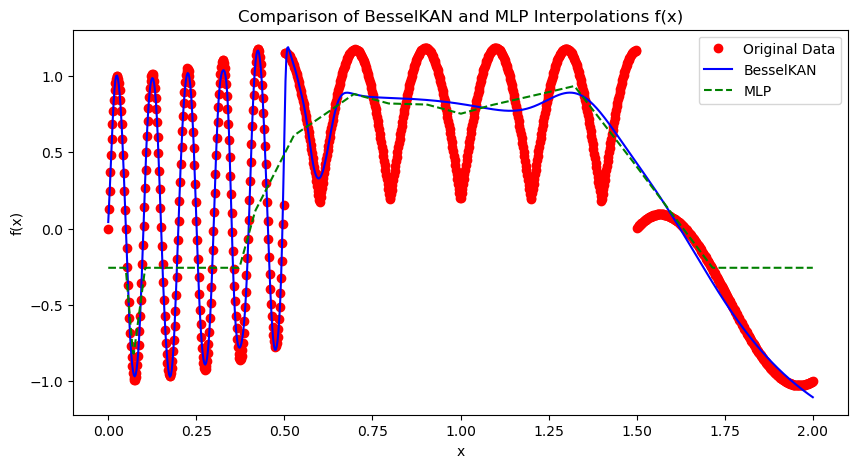

In [16]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=1000).unsqueeze(1)
y_train = torch.tensor(target_function(x_train))

# Instantiate models
bessel_model = BesselKAN()
mlp_model = SimpleMLP()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_bessel = torch.optim.Adam(bessel_model.parameters(), lr=0.01)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.01)

# Train the models
epochs = 3000
for epoch in range(epochs):
    optimizer_bessel.zero_grad()
    outputs_bessel = bessel_model(x_train)
    loss_bessel = criterion(outputs_bessel, y_train)
    loss_bessel.backward()
    optimizer_bessel.step()

    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, BesselKAN Loss: {loss_bessel.item():.4f}, MLP Loss: {loss_mlp.item():.4f}')

# Test the models
x_test = torch.linspace(0, 2, steps=800).unsqueeze(1)
y_pred_bessel = bessel_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data')
plt.plot(x_test.numpy(), y_pred_bessel.numpy(), 'b-', label='BesselKAN')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'g--', label='MLP')
plt.title('Comparison of BesselKAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()